# Data Preparation

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# Where you want the dataset stored
data_dir = "./data"

# Simple transform (you can change later)
transform = transforms.Compose([
    transforms.ToTensor()
])

# This will:
# - CHECK if CIFAR-100 exists in data_dir
# - DOWNLOAD it if missing
train_dataset = datasets.CIFAR100(
    root=data_dir,
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.CIFAR100(
    root=data_dir,
    train=False,
    transform=transform,
    download=True
)
print("CIFAR-100 ready!")
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

/home/wizard/deep_learning_ws/my_env/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


CIFAR-100 ready!
Train samples: 50000
Test samples: 10000


In [ ]:
type(train_dataset)  # Should be torchvision.datasets.CIFAR100


torchvision.datasets.cifar.CIFAR100

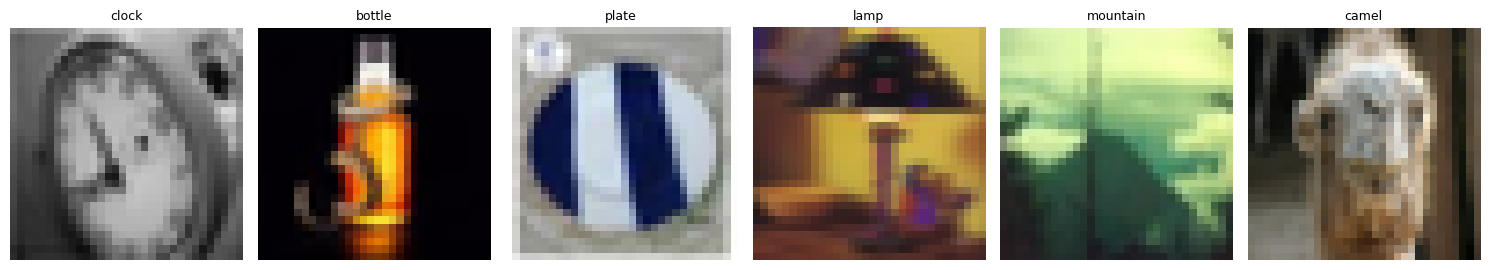

In [51]:


import random

num_samples = 6
indices = random.sample(range(len(train_dataset)), num_samples)

plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(train_dataset.classes[label], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [53]:
type(image)  # Should be torch.Tensor
print(image.shape)  # Should be torch.Size([3, 32, 32])

torch.Size([3, 32, 32])


# Baseline Training

In [26]:
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
print("DataLoaders ready!")

DataLoaders ready!


In [34]:
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [15]:
model = models.resnet18(pretrained=False)


# Modify first layer for CIFAR
model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)
model.maxpool = nn.Identity()

# Modify classifier
model.fc = nn.Linear(model.fc.in_features, 100)

model = model.to(device)


In [36]:
print(model.fc.in_features)

512


In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [29]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    return running_loss / len(loader), acc


In [30]:
def evaluate(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    return loss / len(loader), acc


In [32]:
epochs = 30

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    test_loss, test_acc = evaluate(
        model, test_loader, criterion
    )

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%")


Epoch [1/30]
  Train Loss: 1.9091, Train Acc: 47.55%
  Test  Loss: 2.0560, Test  Acc: 44.15%
Epoch [2/30]
  Train Loss: 1.5288, Train Acc: 56.37%
  Test  Loss: 1.8784, Test  Acc: 48.78%
Epoch [3/30]
  Train Loss: 1.1965, Train Acc: 64.96%
  Test  Loss: 1.8228, Test  Acc: 50.77%
Epoch [4/30]
  Train Loss: 0.8819, Train Acc: 73.22%
  Test  Loss: 1.7845, Test  Acc: 53.29%
Epoch [5/30]
  Train Loss: 0.5933, Train Acc: 81.66%
  Test  Loss: 1.9132, Test  Acc: 52.46%
Epoch [6/30]
  Train Loss: 0.3464, Train Acc: 89.27%
  Test  Loss: 2.3154, Test  Acc: 50.00%
Epoch [7/30]
  Train Loss: 0.2050, Train Acc: 93.79%
  Test  Loss: 2.4497, Test  Acc: 50.92%
Epoch [8/30]
  Train Loss: 0.1460, Train Acc: 95.63%
  Test  Loss: 2.5862, Test  Acc: 51.65%
Epoch [9/30]
  Train Loss: 0.1391, Train Acc: 95.81%
  Test  Loss: 2.5252, Test  Acc: 52.78%
Epoch [10/30]
  Train Loss: 0.1325, Train Acc: 95.81%
  Test  Loss: 2.5516, Test  Acc: 53.77%
Epoch [11/30]
  Train Loss: 0.1143, Train Acc: 96.33%
  Test  Loss: 2

In [6]:
import torch
import os

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "resnet18_cifar100.pth")

torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to ./checkpoints/resnet18_cifar100.pth


In [16]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [12]:
type(model)

torchvision.models.resnet.ResNet

In [17]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

# Baseline Evaluation

## Failure cases

# Modified-model training

# Modified-model Evaluation

# Performance Comparison